* Compare fresh water transport across different river flow conditions, especially looking at effects of Coriolis force and winds.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':55,  'ist': 1,'jen':56,'ien':25},
            '7':{'jst':25,'ist':1, 'jen':26,'ien':25}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.8, 49.7)

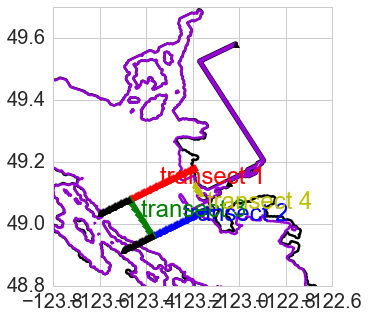

In [5]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[55,0:25],Y[55,0:25],'k^')
ax.plot(X[25,0:25],Y[25,0:25],'k^')
ax.plot(X[120:121,155],Y[120:121,155],'k^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.8,-122.6])
ax.set_ylim([48.8,49.7])

In [6]:
## load salinity into a dict
pathsoct = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
pathsmay = ['May2015OnlyRiver','May2015notides','May2015nowind','May2015nof','May2015combineall']
pathsjan = ['Jan2016OnlyRiver','Jan2016notides','Jan2016nowind','Jan2016nof','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']
        depT = fT.variables['deptht']

In [7]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depT,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [8]:
def transport_time_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j+1,1])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst']+1,transects[tran]['ist']+1]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,1,i+1])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst']+1,i+transects[tran]['ist']+1]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [9]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for daily case, over selected depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 paths,fresh_flag = fresh_flag)
    inte_trans = {}; 
    for ty in paths:
        inte_trans[ty] = np.zeros((ten[ty]-tst[ty]+1)/24)
        for i in np.arange(tst[ty],ten[ty]+1,24): ## intergral individual daily
            inte_trans[ty][i/24-tst[ty]/24] = np.nansum(trans[ty][i:i+24,depT[0]:depT[dep]+1])*3600
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in paths:
        ax.plot(ssh[ty][tst[ty]:ten[ty]+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case
    for ty in paths:
        ax.plot(inte_trans[ty],'o',label = ty,markersize = 10)
        if fresh_flag == 'fresh':
            ax.set_ylabel('fresh water flux $m^3$')
        else:
            ax.set_ylabel('flux $m^3$')
        ax.set_xlim([-1,(ten[ty]+1-tst[ty])/24])
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')
    return inte_trans

In [10]:
def freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,tran,tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag):
    """Plot freshwater time series in a month for different river flows"""
    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(3, 2,width_ratios=[0.4,1], height_ratios=[1,1,1])  
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])
    ax4 = fig.add_subplot(gs[2,1])
    ## plot transect
    viz_tools.plot_coastline(ax1, grid6, coords = 'map')
    
    ax1.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],\
             Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],'r^')        
    ax1.set_xlim([-123.6,-122.6])
    ax1.set_ylim([48.9,49.7])
    trans = {};trans_surf = {};trans_to = {}
    ## plot oct freshwater
    for path, month, tst,ten,ax in zip([paths_oct,paths_may,paths_jan],['oct','may','jan'],\
                                       [tst_oct,tst_may,tst_jan],[ten_oct,ten_may,ten_jan],[ax2,ax3,ax4]):
        trans[month],trans_surf[month],trans_to[month] = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 path,fresh_flag = fresh_flag)
        for pa in path:
            ax.plot(trans_to[month][pa],label = pa)
            ax.legend(loc = 'best') 
    ax2.set_ylabel('Freshwater transport [$m^3$]')
    ax4.set_xlabel('Time [hr]')
    return trans_to

In [29]:
def freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,tran,tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag):
    """Plot freshwater time series in a month for different river flows"""
    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(3, 2,width_ratios=[0.4,1], height_ratios=[1,1,1])  
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])
    ax4 = fig.add_subplot(gs[2,1])
    ## plot transect
    viz_tools.plot_coastline(ax1, grid6, coords = 'map')
    
    ax1.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],\
             Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],'r^')        
    ax1.set_xlim([-123.6,-122.6])
    ax1.set_xticks([-123.6,-123.2,-122.8])
    ax1.set_xticklabels([-123.6,-123.2,-122.8])
    ax1.set_ylim([48.9,49.7])
    trans = {};trans_surf = {};trans_to = {}
    ## plot oct freshwater
    for path, month, tst,ten,ax in zip([paths_oct,paths_may,paths_jan],['oct','may','jan'],\
                                       [tst_oct,tst_may,tst_jan],[ten_oct,ten_may,ten_jan],[ax2,ax3,ax4]):
        trans[month],trans_surf[month],trans_to[month] = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 path,fresh_flag = fresh_flag)
        for pa in path:
            ax.plot(np.cumsum(np.nansum(np.nansum(trans[month][pa][:,0:10], axis= 1),axis  =1)),\
                    label = pa)
            ax.legend(loc = 'best') 
            
        if fresh_flag == 'fresh':            
            if tran == '1':
                ax.set_ylim([-3e6, 1.5e6])
                ax.set_yticklabels([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5])

        ax.text(0,0.9,month, transform = ax.transAxes,fontsize = 29)
    if fresh_flag == 'fresh':
        ax2.set_ylabel(r' Cumulative freshwater transport $\mathrm{(\times 10^6 m^3)}$')
    elif fresh_flag == False:
        ax2.set_ylabel(r' Cumulative volume transport $\mathrm{(m^3)}$')
    ax4.set_xlabel('Time (hr)')
    plt.show()
    return trans

In [12]:
paths_oct = ['Oct2014nowind','Oct2014OnlyRiver','Oct2014nof','Oct2014combineall']
paths_may = ['May2015nowind','May2015OnlyRiver','May2015nof','May2015combineall']
paths_jan = ['Jan2016nowind','Jan2016OnlyRiver','Jan2016nof','Jan2016combineall'];
tst_oct = {'Oct2014nowind':0,'Oct2014OnlyRiver':0,'Oct2014nof':0,'Oct2014combineall':0}
ten_oct = {'Oct2014nowind':743,'Oct2014OnlyRiver':743,'Oct2014nof':743,'Oct2014combineall':743}
tst_may = {'May2015nowind':0,'May2015OnlyRiver':0,'May2015nof':0,'May2015combineall':0}
ten_may = {'May2015nowind':743,'May2015OnlyRiver':743,'May2015nof':743,'May2015combineall':743}
tst_jan = {'Jan2016nowind':0,'Jan2016OnlyRiver':0,'Jan2016nof':0,'Jan2016combineall':0}
ten_jan = {'Jan2016nowind':743,'Jan2016OnlyRiver':743,'Jan2016nof':743,'Jan2016combineall':743}

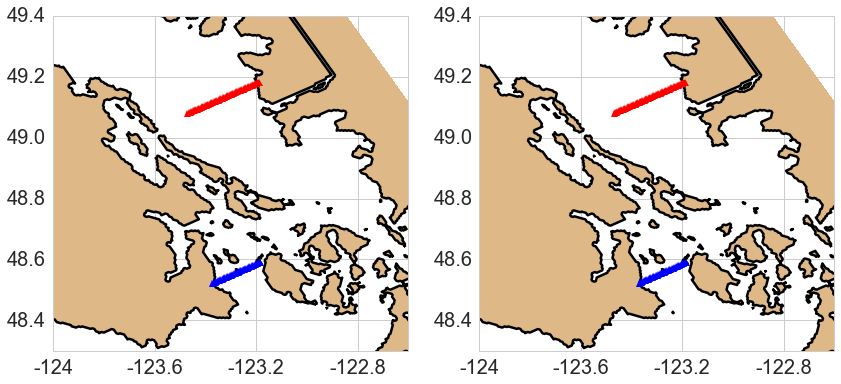

In [37]:
lon = grid6.variables['nav_lon']
lat =grid6.variables['nav_lat']
fig, axs = plt.subplots(1,2,figsize = (14,6))
for ax in axs:
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.6])
    ax.set_xticks([-124,-123.6,-123.2,-122.8])
    ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
    ax.set_ylim([48.3,49.4])
    ax.plot(X[55,25:80],Y[55,25:80],'r^')
    ax.plot(lon[320,210:247],lat[320,210:247],'b^')

$\heartsuit$

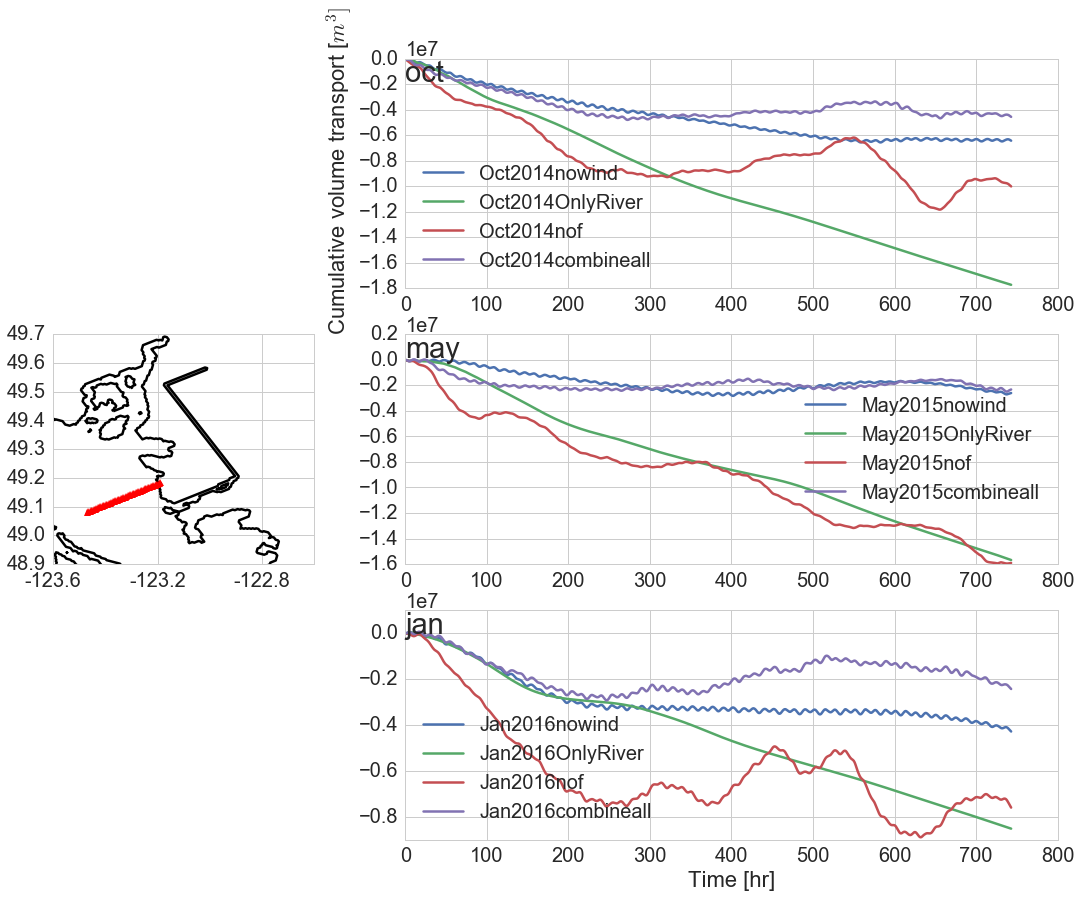

In [49]:
## upper 10 m cumsum volumn at north transect
trans_toUpperVolume = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag=False)

In [13]:
def Plot_VolumeFreshTransport(axs,trans_toUpperVolume,trans_toUpper,mon,path):
    """
    Plot cumsum volume/freshwater flux with time
    """
    ax =axs[0]
    ax.plot(np.cumsum(np.nansum(np.nansum(trans_toUpperVolume[mon][path][:,0:10],axis=1),axis=1)),'-*')
    ax.set_ylabel('Cumulative Volume flux')
    ax = axs[1]
    ax.plot(np.cumsum(np.nansum(np.nansum(trans_toUpper[mon][path][:,0:10],axis=1),axis=1)),'-*')
    ax.set_ylabel('Cumulative freshwater flux')
    ax.set_xlabel('Time [hr]')
    plt.show()

In [14]:
def Plot_change_with_time_spaceCumsum(axs,trans_toUpperVolume,trans_toUpper,mon,path,vmin,vmax):
    """
    Plot the cumsum volume/freshwater transport with time and along transect
    """
    ax= axs[0]
    volume_space_time = np.nansum(trans_toUpperVolume[mon][path][:,0:10,:],axis=1) ## volume change with time &space
    mesh = ax.pcolormesh(np.cumsum(volume_space_time,axis =0),cmap = 'bwr',vmin = vmin, vmax = vmax)
    cbar=fig.colorbar(mesh,ax =ax)
    ax =axs[1]
    freshwater_space_time = np.nansum(trans_toUpper[mon][path][:,0:10,:],axis=1) ## freshwater change with time&space
    mesh = ax.pcolormesh(np.cumsum(freshwater_space_time,axis = 0),cmap = 'bwr',vmin = vmin, vmax = vmax)
    cbar=fig.colorbar(mesh,ax =ax)
    ax.set_xlabel('x index of transect')
    for ax in axs:
        ax.set_ylabel('Time')
        ax.set_xlim([0,55])
    plt.show()

In [45]:
def Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,mon,path,vmin_vo,vmax_vo,\
                                             vmin_fr,vmax_fr):
    """
    Plot daily integral of volume/freshwater transport with time and along transect
    """
    volume_space_time = np.nansum(trans_toUpperVolume[mon][path][:,0:10,:],axis=1) ## volume change with time &space
    freshwater_space_time = np.nansum(trans_toUpper[mon][path][:,0:10,:],axis=1) ## freshwater change with time&space
    Volume_space_time = np.zeros([31,volume_space_time.shape[1]])
    Freshwater_space_time = np.zeros([31,freshwater_space_time.shape[1]])
    for t in np.arange(0,744,24):
        Volume_space_time[t/24] = np.nansum(volume_space_time[t:t+24],axis = 0)
        Freshwater_space_time[t/24] = np.nansum(freshwater_space_time[t:t+24],axis = 0)
        
    ax= axs[0]    
    mesh = ax.pcolormesh(Volume_space_time,cmap = 'bwr',vmin = vmin_vo, vmax = vmax_vo)
    cbar=fig.colorbar(mesh,ax =ax)
    ax =axs[1]
    
    mesh = ax.pcolormesh(Freshwater_space_time,cmap = 'PiYG_r',vmin = vmin_fr, vmax = vmax_fr)
    cbar=fig.colorbar(mesh,ax =ax)
    ax.set_xlabel('x index of transect')
    for ax in axs:
        ax.set_ylabel('Time')
        ax.set_xlim([0,55])
        ax.set_ylim([0,30])
    plt.show()

# Volumn/freshwater transport change with time along the transect

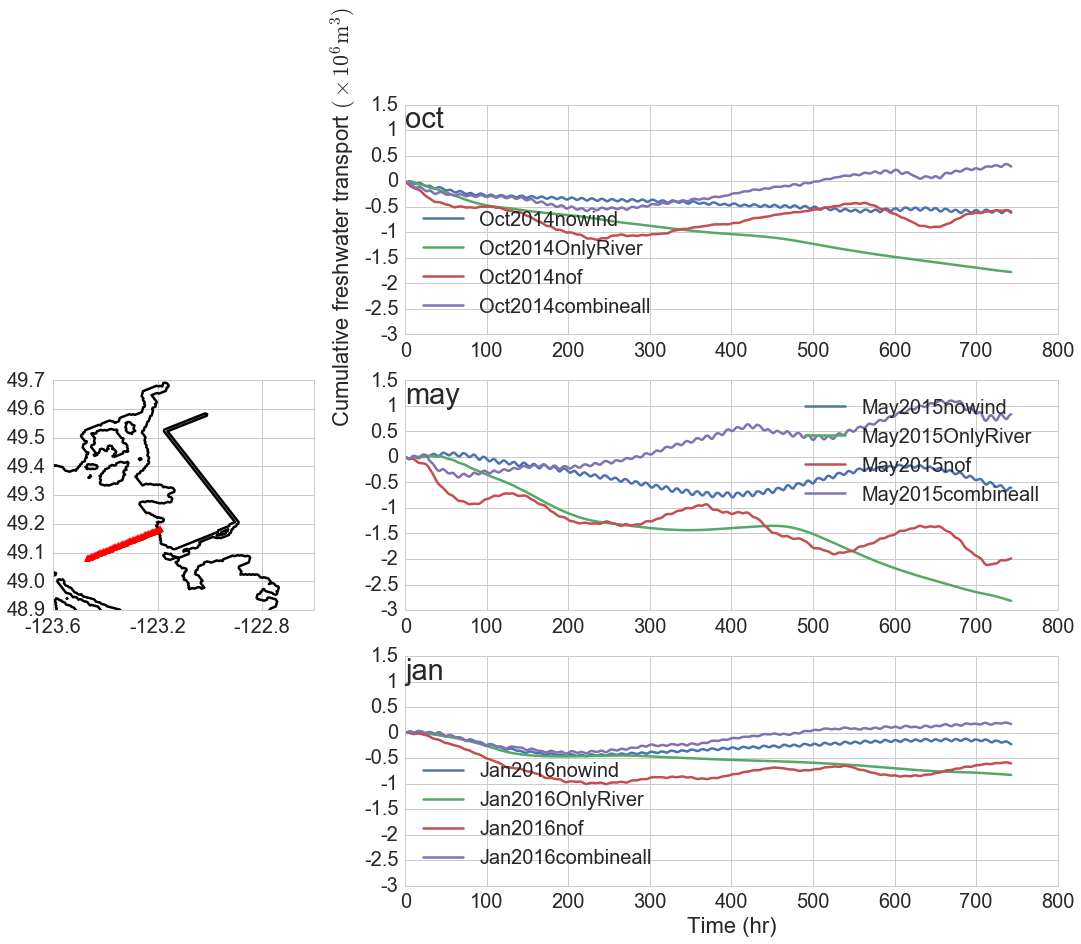

In [30]:
## upper box 10m cumsum at north transect
trans_toUpper = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

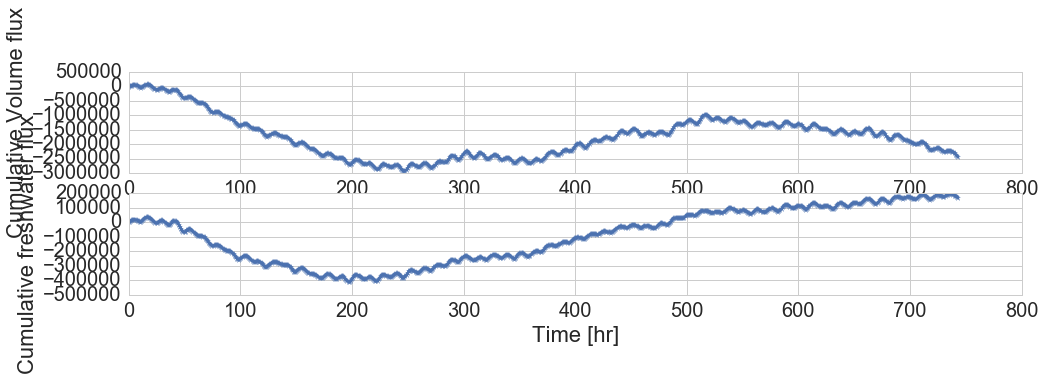

In [297]:
##Jan all
fig, axs = plt.subplots(2,1,figsize = (16,4))
Plot_VolumnFreshTransport(axs,trans_toUpperVolume,trans_toUpper,'jan','Jan2016combineall')

# Daily integral

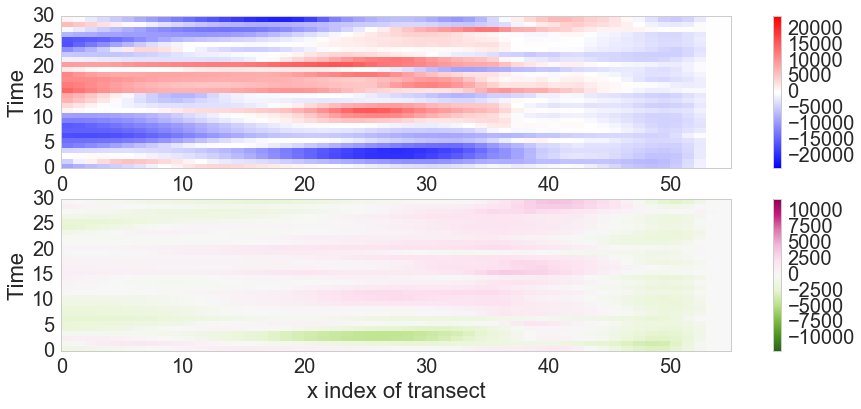

In [46]:
## Jan all
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'jan','Jan2016combineall',-24e3,24e3,\
                                        -12e3,12e3)

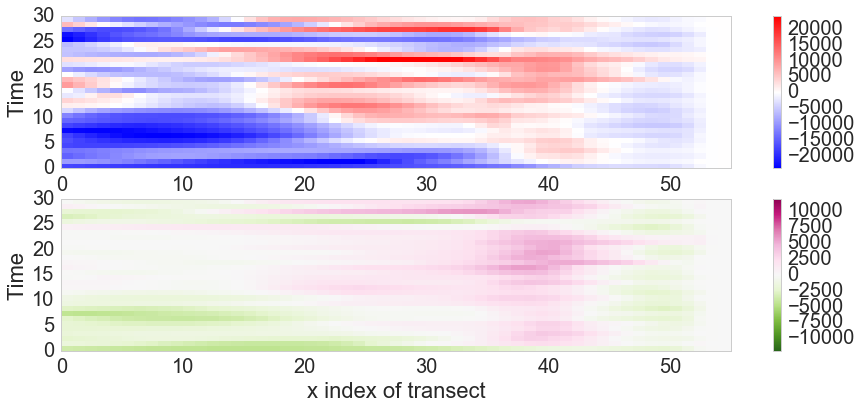

In [47]:
## Oct all
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'oct','Oct2014combineall',-24e3,24e3,
                                        -12e3,12e3)

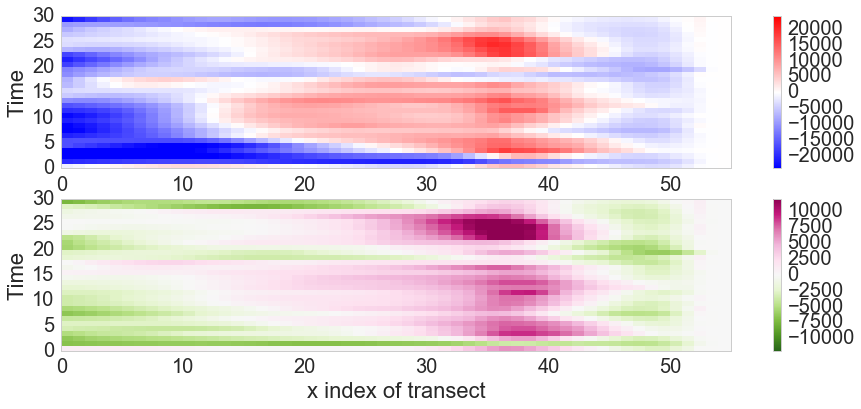

In [48]:
## may all
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'may','May2015combineall',-24e3,24e3,
                                        -12e3,12e3)

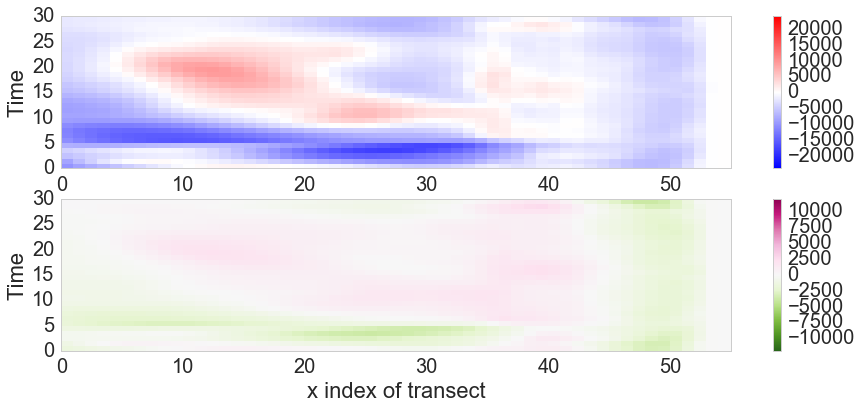

In [49]:
## Jan nowind
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'jan','Jan2016nowind',-24e3,24e3,
                                         -12e3,12e3)

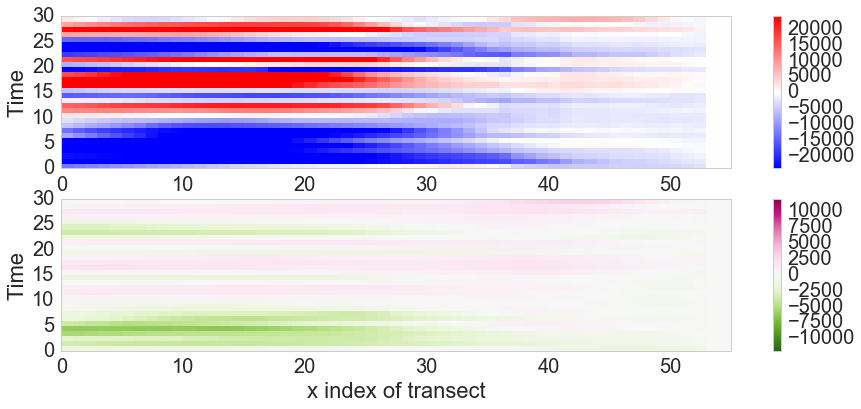

In [50]:
## Jan nof
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'jan','Jan2016nof',-24e3,24e3,
                                        -12e3,12e3)

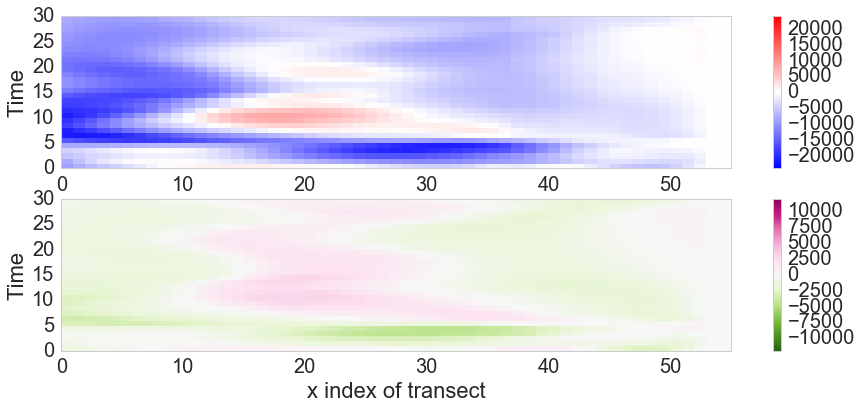

In [51]:
## Jan onlyriver
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'jan','Jan2016OnlyRiver',-24e3,24e3,
                                        -12e3,12e3)

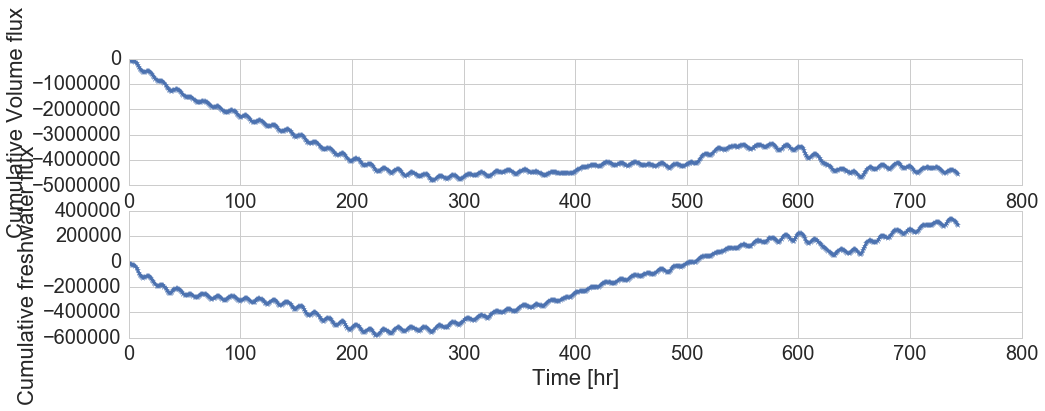

In [298]:
##Oct all
fig, axs = plt.subplots(2,1,figsize = (16,5))
Plot_VolumnFreshTransport(axs,trans_toUpperVolume,trans_toUpper,'oct','Oct2014combineall')

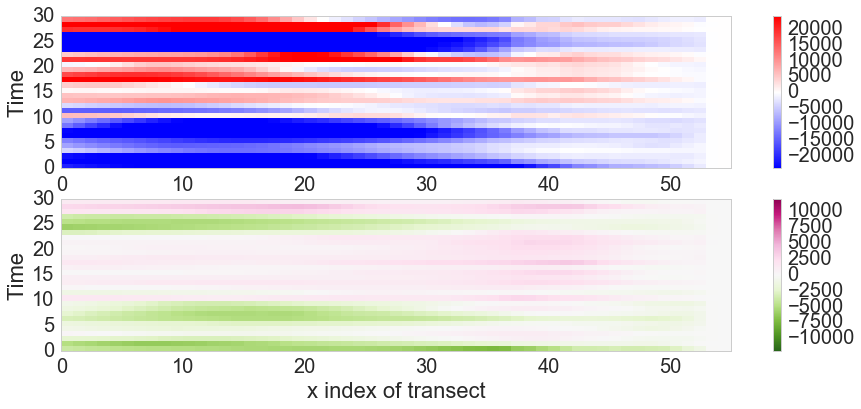

In [52]:
## Oct nof
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'oct','Oct2014nof',-24e3,24e3,
                                        -12e3,12e3)

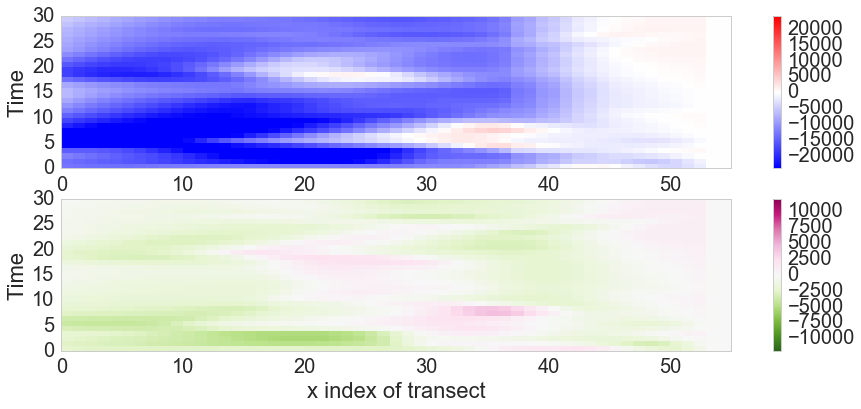

In [53]:
## Oct onlyriver
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'oct','Oct2014OnlyRiver',-24e3,24e3,
                                        -12e3,12e3)

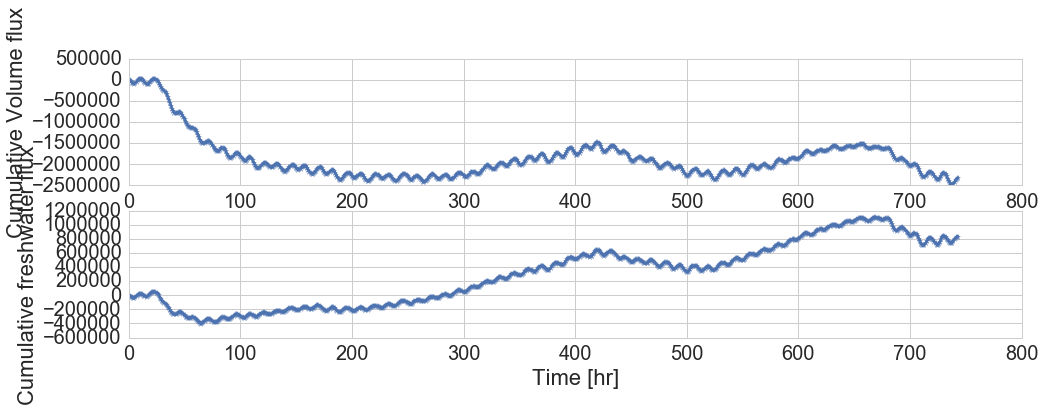

In [299]:
##May all
fig, axs = plt.subplots(2,1,figsize = (16,5))
Plot_VolumnFreshTransport(axs,trans_toUpperVolume,trans_toUpper,'may','May2015combineall')

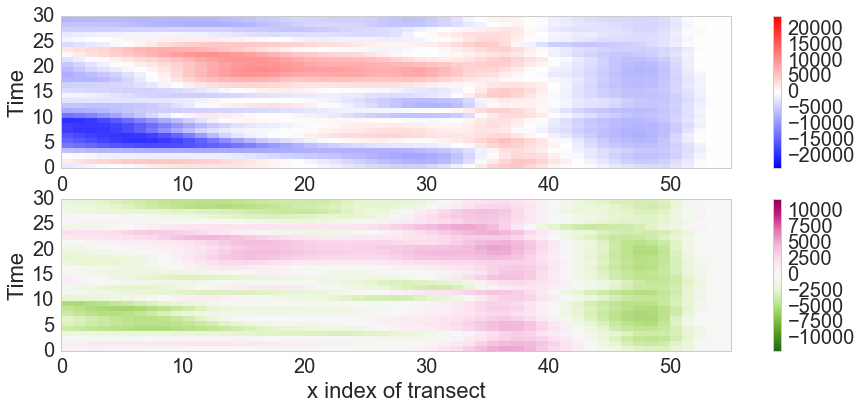

In [54]:
## may nowind
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'may','May2015nowind',-24e3,24e3,
                                        -12e3,12e3)

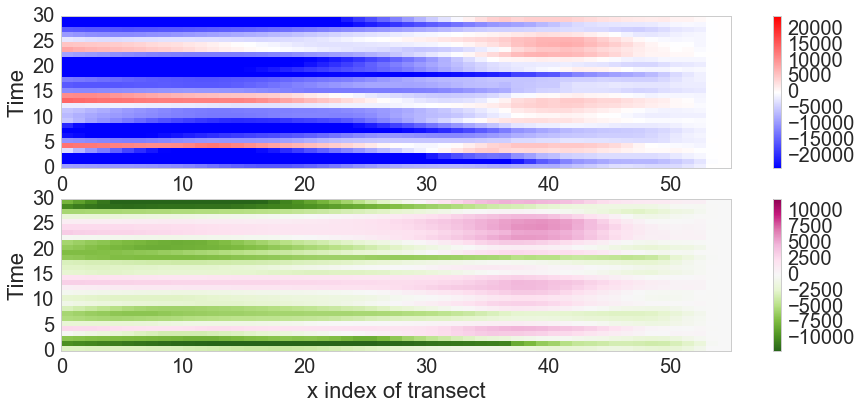

In [55]:
## may nof
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'may','May2015nof',-24e3,24e3,
                                        -12e3,12e3)

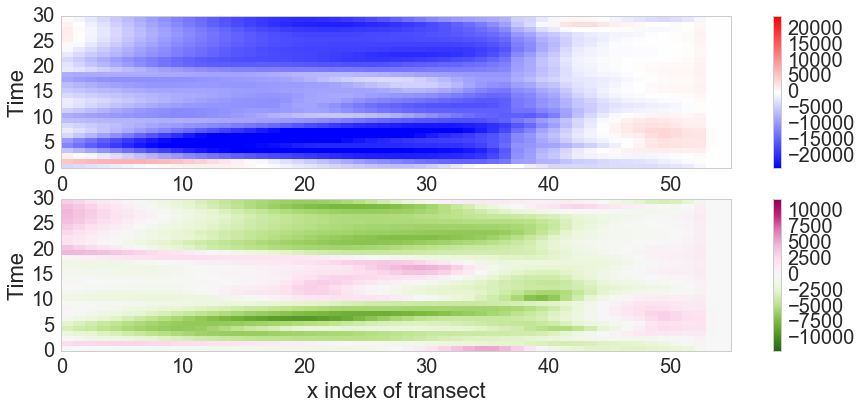

In [56]:
## may onlyriver
fig, axs = plt.subplots(2,1,figsize = (15,6))
Plot_change_with_time_spaceDailyIntegral(axs,trans_toUpperVolume,trans_toUpper,'may','May2015OnlyRiver',-24e3,24e3,
                                        -12e3,12e3)

# Only v integral over upper 10 m or v delta S/S0 over upper 10 m plot

In [191]:
tran ='1'
V_depth_integral = {}
fresh_depth_integral = {}
for run in ['Jan2016combineall','Oct2014combineall','May2015combineall']:
    V_depth_integral[run] = np.zeros([744,10,55])
    fresh_depth_integral[run] = np.zeros([744,10,55])

In [192]:
for run in ['Jan2016combineall','Oct2014combineall','May2015combineall']:
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    UU = np.zeros([744,10,jinds.shape[0],iinds.shape[0]]); 
    VV= np.zeros([744,10,jinds.shape[0],iinds.shape[0]]);
    SS = np.zeros([744,10,jinds.shape[0],iinds.shape[0]])
    SS= S[run][:,:,jinds,iinds]    
    mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
    for t in np.arange(744):
        SS[t] = np.ma.masked_array(SS[t],mask=mask) ## mask sal=0 by tmask 

    UU,VV = viz_tools.unstagger(U[run][:,0:10,jinds,iinds],V[run][:,0:10,jinds,iinds]) ## unstagger u and v
    for t in np.arange(744):
        for z in np.arange(10):
            for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                adj_ssh = 1+ssh[run][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])
                ratio = (30 - SS[t,z,1,i+1])/30

                V_depth_integral[run][t,z,i] = VV[t,z,0,i]*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh
                fresh_depth_integral[run][t,z,i] = VV[t,z,0,i]*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio

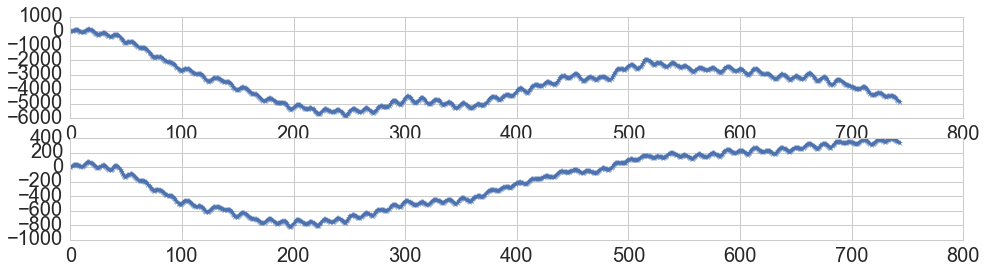

In [291]:
##Jan
fig, axs = plt.subplots(2,1,figsize = (16,4))
ax =axs[0]
ax.plot(np.cumsum(np.nansum(np.nansum(V_depth_integral['Jan2016combineall'],axis = 1),axis=1)),'-*')
ax = axs[1]
ax.plot(np.cumsum(np.nansum(np.nansum(fresh_depth_integral['Jan2016combineall'],axis=1),axis=1)),'-*')

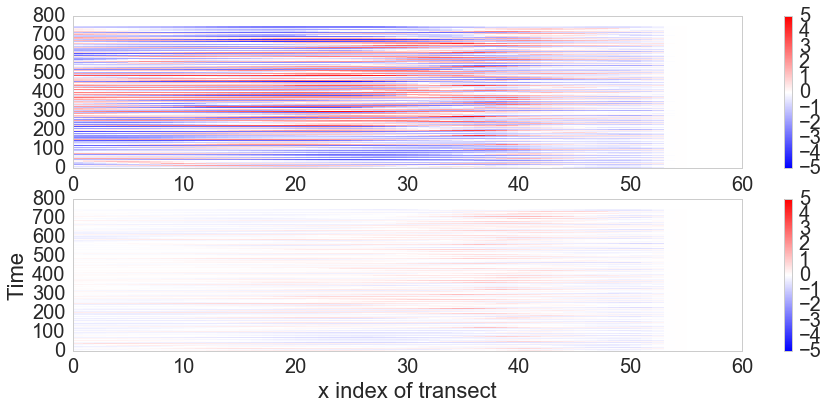

In [292]:
## Jan
fig,axs = plt.subplots(2,1,figsize = (15,6))
ax= axs[0]
volume_space_time = np.nansum(V_depth_integral['Jan2016combineall'],axis = 1)
mesh = ax.pcolormesh(volume_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax =axs[1]
freshwater_space_time = np.nansum(fresh_depth_integral['Jan2016combineall'],axis = 1)
## freshwater change with transect and time
mesh = ax.pcolormesh(freshwater_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax.set_xlabel('x index of transect')
ax.set_ylabel('Time')

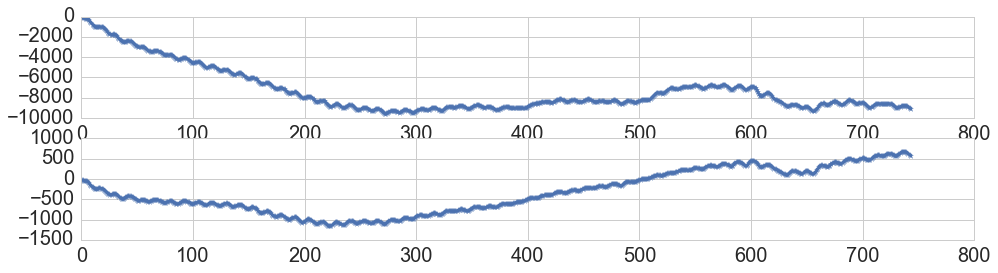

In [293]:
##Oct
fig, axs = plt.subplots(2,1,figsize = (16,4))
ax =axs[0]
ax.plot(np.cumsum(np.nansum(np.nansum(V_depth_integral['Oct2014combineall'],axis = 1),axis=1)),'-*')
ax = axs[1]
ax.plot(np.cumsum(np.nansum(np.nansum(fresh_depth_integral['Oct2014combineall'],axis=1),axis=1)),'-*')

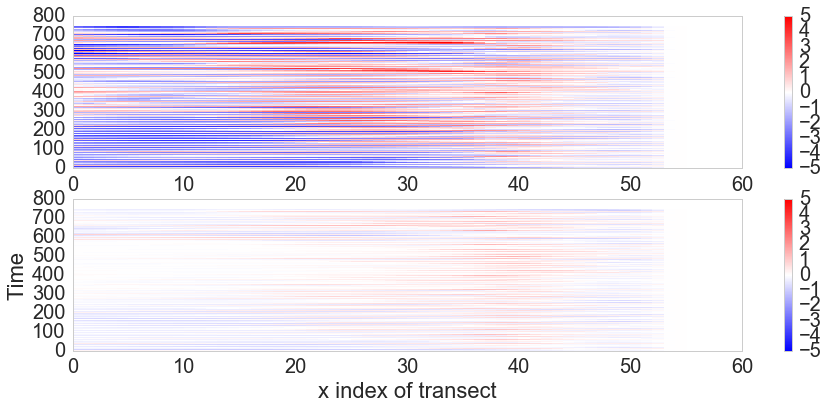

In [294]:
## Oct
fig,axs = plt.subplots(2,1,figsize = (15,6))
ax= axs[0]
volume_space_time = np.nansum(V_depth_integral['Oct2014combineall'],axis = 1)
mesh = ax.pcolormesh(volume_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax =axs[1]
freshwater_space_time = np.nansum(fresh_depth_integral['Oct2014combineall'],axis = 1)
## freshwater change with transect and time
mesh = ax.pcolormesh(freshwater_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax.set_xlabel('x index of transect')
ax.set_ylabel('Time')

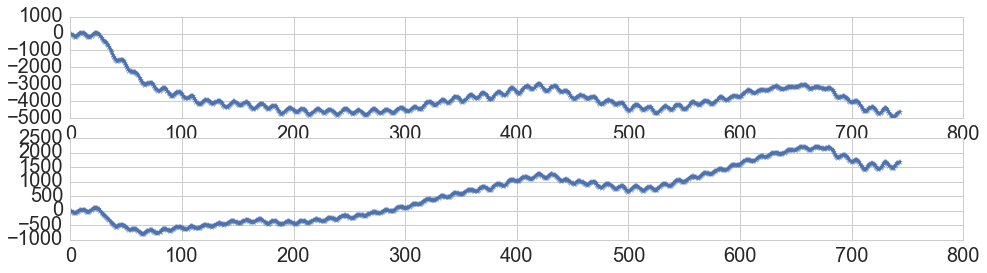

In [295]:
##May
fig, axs = plt.subplots(2,1,figsize = (16,4))
ax =axs[0]
ax.plot(np.cumsum(np.nansum(np.nansum(V_depth_integral['May2015combineall'],axis = 1),axis=1)),'-*')
ax = axs[1]
ax.plot(np.cumsum(np.nansum(np.nansum(fresh_depth_integral['May2015combineall'],axis=1),axis=1)),'-*')

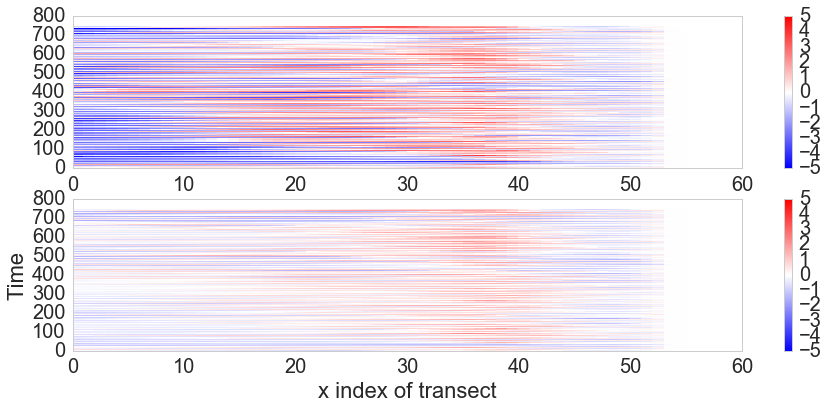

In [296]:
## plot depth integral v first! 
fig,axs = plt.subplots(2,1,figsize = (15,6))
ax= axs[0]
volume_space_time = np.nansum(V_depth_integral['May2015combineall'],axis = 1)
mesh = ax.pcolormesh(volume_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax =axs[1]
freshwater_space_time = np.nansum(fresh_depth_integral['May2015combineall'],axis = 1)
## freshwater change with transect and time
mesh = ax.pcolormesh(freshwater_space_time,cmap = 'bwr',vmin = -5,vmax = 5)
cbar=fig.colorbar(mesh,ax =ax)
ax.set_xlabel('x index of transect')
ax.set_ylabel('Time')

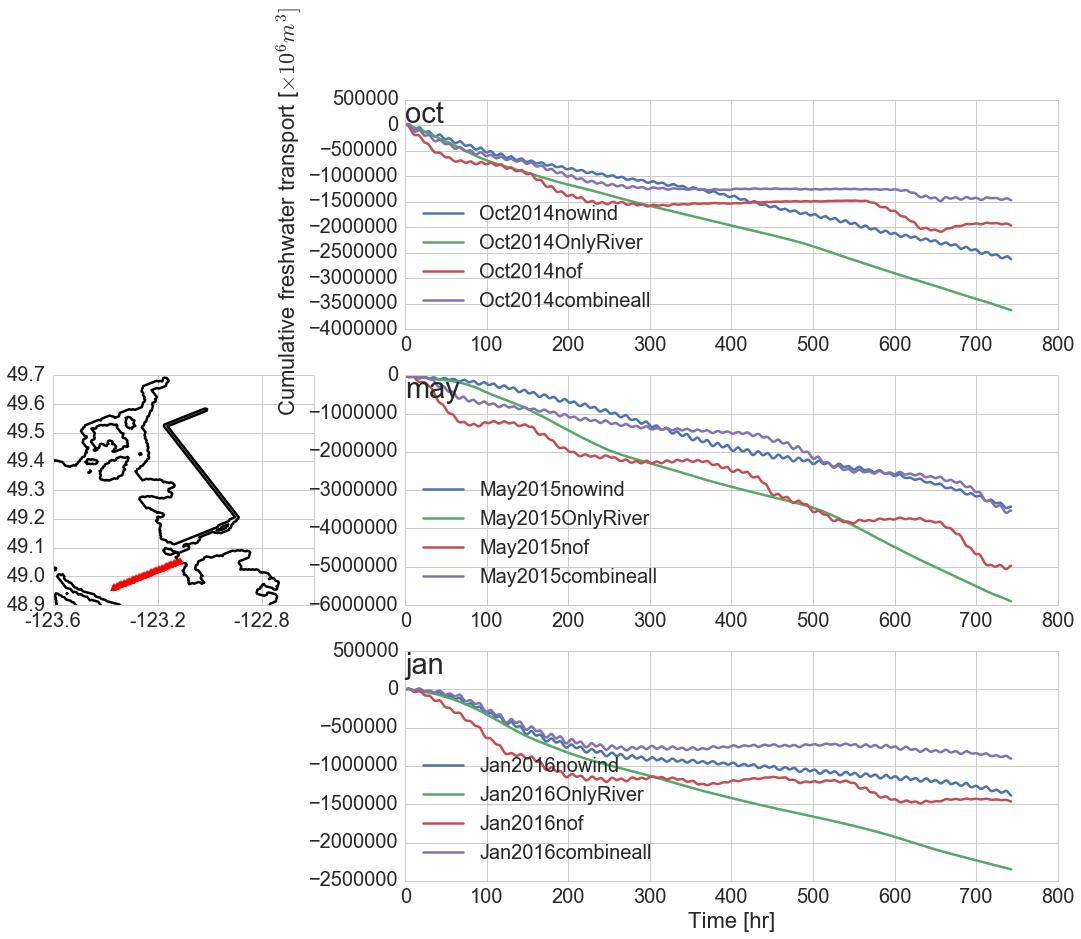

In [204]:
## upper box 10m cumsum at south transect
trans_toSouth = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'2',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

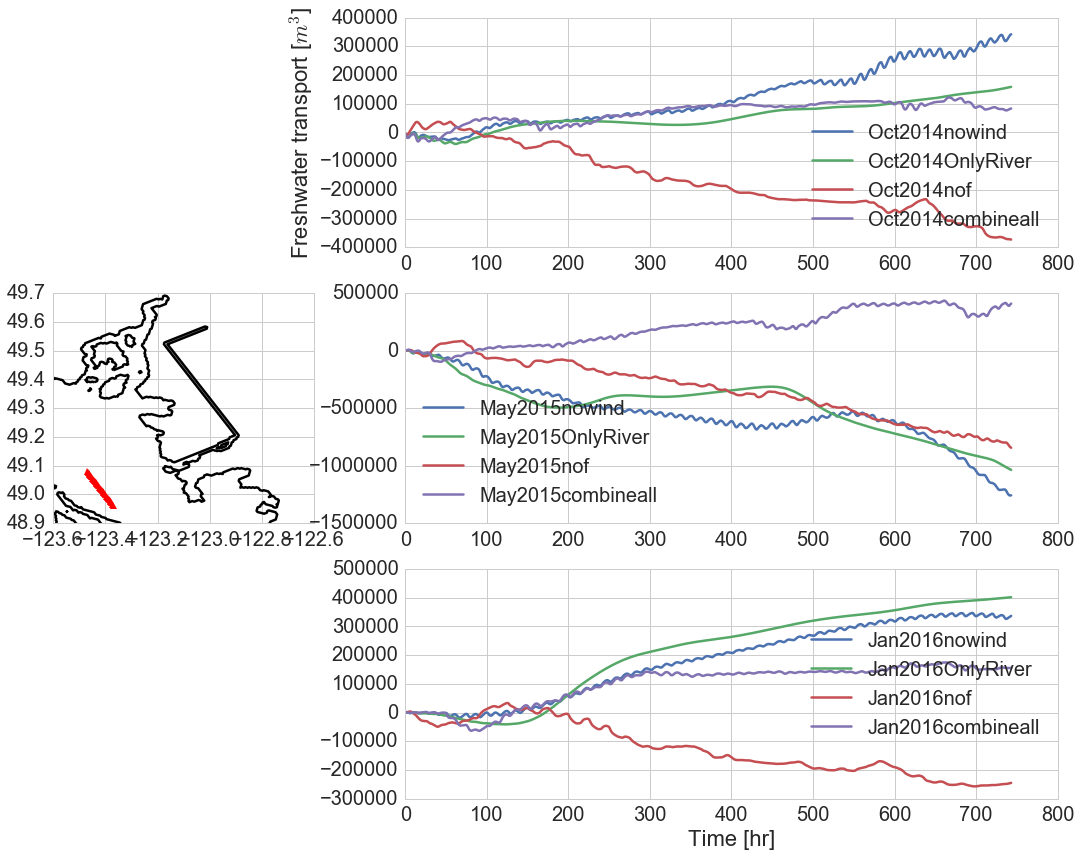

In [14]:
## upper box 10m cumsum at west transect
trans_toWest = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'3',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

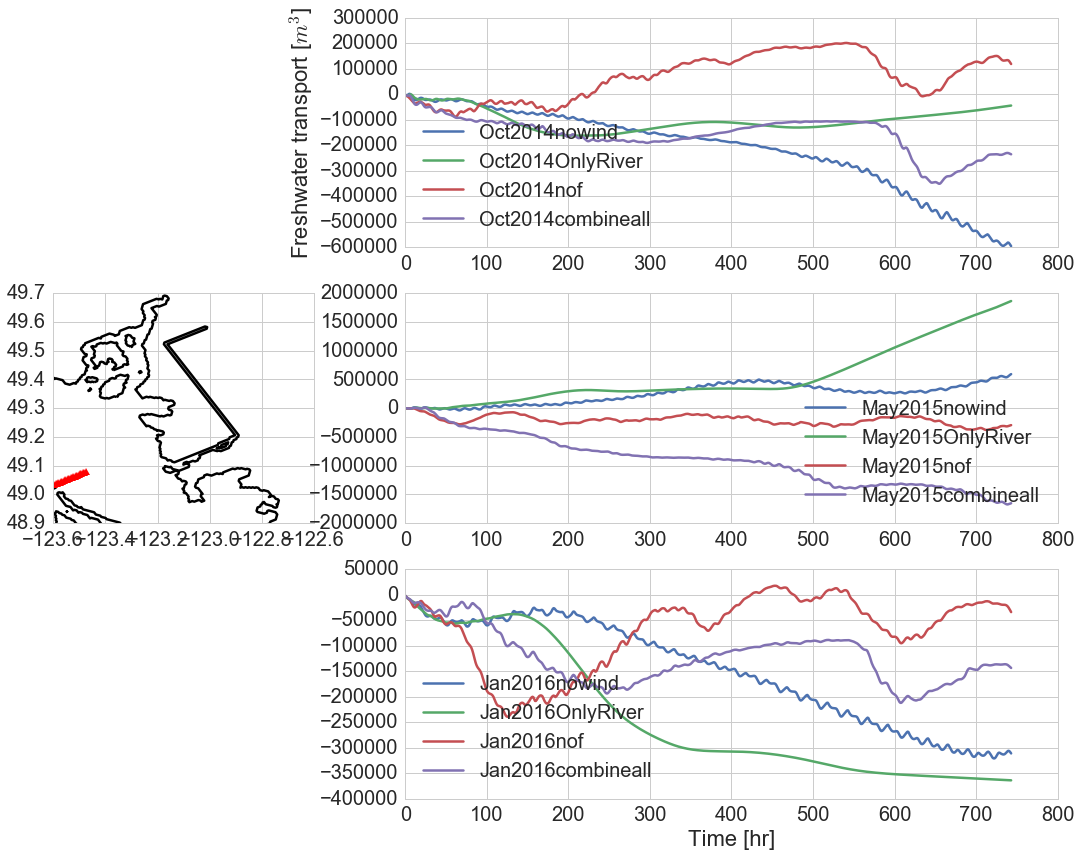

In [17]:
## upper box 10m cumsum at northwest transect
trans_toNW = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'6',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

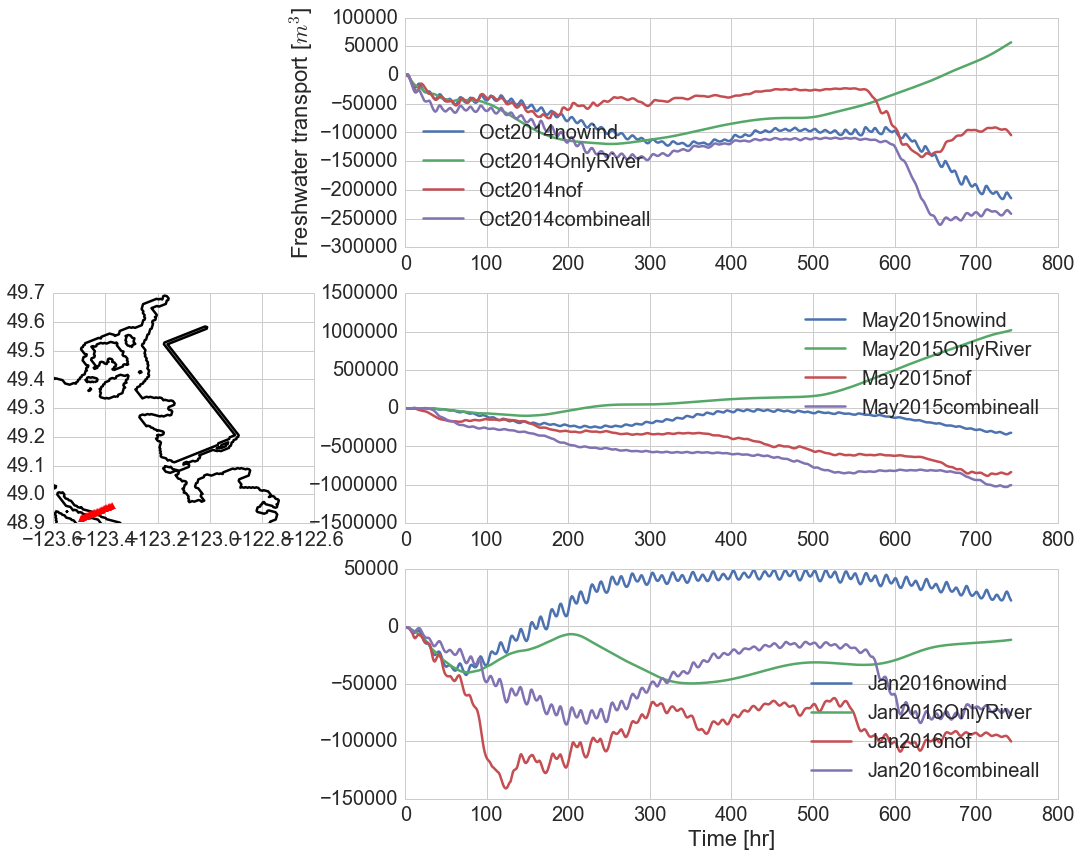

In [18]:
## upper box 10m cumsum at southwest transect
trans_toSW = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'7',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')